Importing the Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing Librosa, soundfile and Keras

In [ ]:
!pip install --upgrade soundfile librosa keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Also installing python speech features

In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=ab3ac5d3d1b0a7fa8b63121667f315e8106113072d114d83953b274d23ab3e2a
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


Extracting the MFCC Features from the audo files

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import soundfile as sf
import librosa
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# Set the path to the folder containing the audio files
data_folder = 'Path of the folder containing the audio files'

# Set the desired number of MFCC coefficients and maximum sequence length
num_coefficients = 13
max_sequence_length = 1000

# Create empty lists to store the MFCC features and speaker labels
mfcc_features = []
speaker_labels = []

# Iterate through the audio files in the folder
for filename in os.listdir(data_folder):
    # the format of the file is: speakerID-index.flac
    # Extract the speaker ID from the filename
    speaker_id = filename.split('-')[0]

    # Load the audio file
    audio, sr = sf.read(os.path.join(data_folder, filename))

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_coefficients)

    # Pad or truncate the MFCC features to the maximum sequence length
    if mfcc.shape[1] < max_sequence_length:
        pad_width = max_sequence_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    else:
        mfcc = mfcc[:, :max_sequence_length]

    # Append the MFCC features and speaker label to the lists
    mfcc_features.append(mfcc)
    speaker_labels.append(speaker_id)

Splitting the extracted MFCC features into train and test labels

In [ ]:
#Convert the lists to numpy arrays
mfcc_features = np.array(mfcc_features)
speaker_labels = np.array(speaker_labels)

# Split the data into training and testing sets
trainMFCC, testMFCC, trainSpeakerIDs, testSpeakerIDs = train_test_split(
    mfcc_features, speaker_labels, test_size=0.2, random_state=42)

# Reshape the input data
trainMFCC = trainMFCC[..., np.newaxis]
testMFCC = testMFCC[..., np.newaxis]

# Convert speaker IDs to numerical labels
unique_speakers = np.unique(speaker_labels)
num_speakers = len(unique_speakers)
label_to_id = {label: i for i, label in enumerate(unique_speakers)}
trainLabels = np.array([label_to_id[label] for label in trainSpeakerIDs])
testLabels = np.array([label_to_id[label] for label in testSpeakerIDs])

Applying CNN Model 

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(num_coefficients, max_sequence_length, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_speakers, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(trainMFCC, trainLabels, epochs=10, batch_size=32, validation_data=(testMFCC, testLabels))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(testMFCC, testLabels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
15/15 [==============================] - 16s 110ms/step - loss: 193.9150 - accuracy: 0.2727 - val_loss: 62.6205 - val_accuracy: 0.4425
Epoch 2/10
15/15 [==============================] - 0s 31ms/step - loss: 30.3124 - accuracy: 0.5255 - val_loss: 17.0842 - val_accuracy: 0.5221
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 8.3062 - accuracy: 0.7361 - val_loss: 4.7067 - val_accuracy: 0.7699
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 2.4487 - accuracy: 0.7494 - val_loss: 3.8992 - val_accuracy: 0.6903
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 0.6581 - accuracy: 0.8581 - val_loss: 1.6503 - val_accuracy: 0.7788
Epoch 6/10
15/15 [==============================] - 0s 28ms/step - loss: 0.3266 - accuracy: 0.9446 - val_loss: 0.6365 - val_accuracy: 0.9027
Epoch 7/10
15/15 [==============================] - 0s 21ms/step - loss: 0.1314 - accuracy: 0.9667 - val_loss: 0.2323 - val_accuracy: 0.9292
Epoch 

Classifcation Report and Confusion Matrix

4/4 [==============================] - 0s 3ms/step
19: 0.9824561403508771
26: 0.9500000000000001
27: 1.0
32: 0.8717948717948718
39: 0.9444444444444444


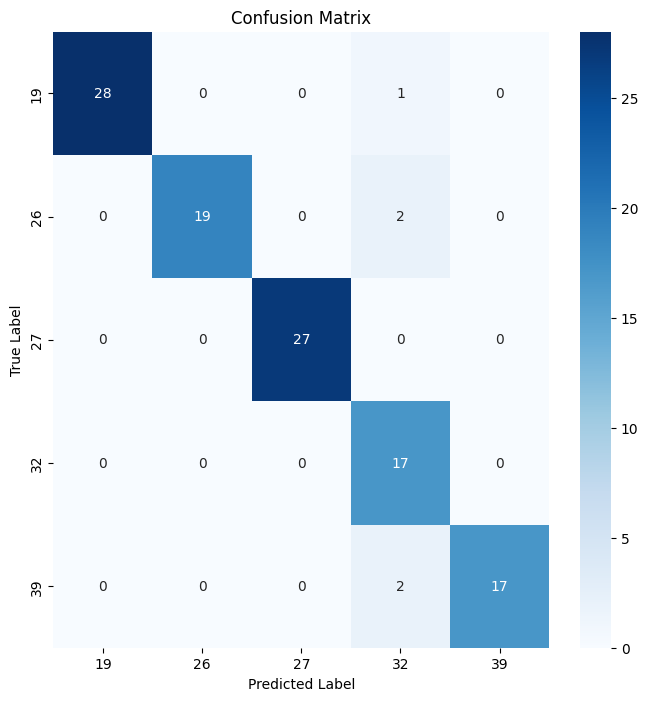


Classification Report:
              precision    recall  f1-score   support

          19       1.00      0.97      0.98        29
          26       1.00      0.90      0.95        21
          27       1.00      1.00      1.00        27
          32       0.77      1.00      0.87        17
          39       1.00      0.89      0.94        19

    accuracy                           0.96       113
   macro avg       0.95      0.95      0.95       113
weighted avg       0.97      0.96      0.96       113



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
predictions = np.argmax(model.predict(testMFCC), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(testLabels, predictions)

# Calculate the classification report
class_names = np.unique(speaker_labels)
report = classification_report(testLabels, predictions, target_names=class_names, output_dict=True)

# Get the F1-score for each class
f1_scores = {label: report[label]['f1-score'] for label in class_names}

# Print the F1-score for each class
for label, f1_score in f1_scores.items():
    print(f"{label}: {f1_score}")

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(testLabels, predictions, target_names=class_names))
